In [1]:
# Creating a Generative Adverserial Network that creates realistic MNIST digit images
import numpy as np

import torch
from torch import nn

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

In [2]:
torch.__version__

'2.5.1+cu118'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Load the MNIST dataset
MNIST_TRAIN = datasets.MNIST(root='/datasets/', train=True, transform=transforms.ToTensor(), download=True)
MNIST_TEST = datasets.MNIST(root='/datasets/', train=False, transform=transforms.ToTensor(), download=True)

In [5]:
# Dataset sizes
len(MNIST_TRAIN), len(MNIST_TEST)

(60000, 10000)

In [6]:
# Single training example
data_sample, label = MNIST_TRAIN[0]
data_sample.shape

torch.Size([1, 28, 28])

In [7]:
# Create the Dataloader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=MNIST_TRAIN, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(dataset=MNIST_TEST, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [8]:
train_iter = iter(train_dataloader)
first_batch_samples, first_batch_labels = next(train_iter)
first_batch_samples.shape, first_batch_labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Visualize a data sample
data_sample, data_label = first_batch_samples[0], first_batch_labels[0]
data_sample.shape, data_label.item()

(torch.Size([1, 28, 28]), 3)

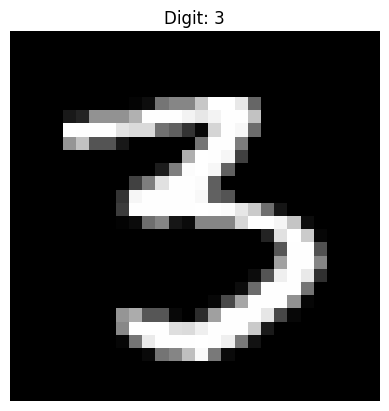

In [11]:
plt.title(f'Digit: {data_label.item()}')
plt.axis(False)
plt.imshow(data_sample.squeeze(dim=0), cmap='gray')

In [12]:
# Creating the GAN
# First, we create the Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_dimension): # image dimension will be 28*28 = 784
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=img_dimension, out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid() # Maps tht output a probability value between 0 to 1
        )

    def forward(self, X):
        return self.layers(X)

In [13]:
# Then, we create the Generator that outputs a random 28*28 grayscale image
class Generator(nn.Module):
    def __init__(self, z_dim, img_dimension):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=256),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=256, out_features=img_dimension),
            nn.Sigmoid(), # Maps all the outputs to values between 0 to 1
        )

    def forward(self, X):
        return self.layers(X)

In [14]:
# Hyperparams
learning_rate = 0.0003
z_dim = 64
epochs = 50

# Constants
image_dim = 28*28*1 # -> 784

In [15]:
# Initialize the models
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn(size=(BATCH_SIZE, z_dim)).to(device)

In [16]:
# Create the loss function and the optimizer
loss_function = nn.BCELoss()
optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate)
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate)

In [17]:
# Training the GAN model
fake_image_samples = []

for epoch in range(epochs):
    batch = 1
    for batch_idx, (real_samples, labels) in enumerate(train_dataloader):
        real_samples = real_samples.flatten(start_dim=1, end_dim=-1).to(device) # -> change shape to [32, 784]
        batch_size = real_samples.shape[0]

        ## Train the discriminator: maximize log(D(real_sample)) + log(1 - D(G(z)))
        # Create the fake samples
        noise = torch.randn(size=(BATCH_SIZE, z_dim)).to(device) # shape -> [32, 64]
        fake_samples = gen(noise) # shape -> [32, 784]
        
        # (A) Send real images through the discriminator
        disc_real = disc(real_samples) # shape [32, 784] -> shape [32, 1]
        disc_real = disc_real.flatten(start_dim=0, end_dim=-1) # shape [32, 1] -> shape [32,]
        loss_disc_real = loss_function(disc_real, torch.ones_like(disc_real)) # Calculate the loss (-log(D(real_sample)))

        # (B) Send fake images through the discriminator
        disc_fake = disc(fake_samples).flatten(start_dim=0, end_dim=-1)
        loss_disc_fake = loss_function(disc_fake, torch.zeros_like(disc_fake)) # (-log(1 - D(G(z))))

        loss = (loss_disc_real + loss_disc_fake) / 2

        optimizer_disc.zero_grad()
        
        loss.backward(retain_graph=True)
        
        optimizer_disc.step()

        ## Train the generator: maximize log(D(G(z)))
        output = disc(fake_samples).flatten(start_dim=0, end_dim=-1)
        loss_gen = loss_function(output, torch.ones_like(output))

        optimizer_gen.zero_grad()
        
        loss_gen.backward()

        optimizer_gen.step()

        batch += 1

        if batch % 100 == 0:
            fake_image_samples.append(fake_samples)
            print(f'Batches seen: {batch}.')

        

Batches seen: 100.
Batches seen: 200.
Batches seen: 300.
Batches seen: 400.
Batches seen: 500.
Batches seen: 600.
Batches seen: 700.
Batches seen: 800.
Batches seen: 900.
Batches seen: 1000.
Batches seen: 1100.
Batches seen: 1200.
Batches seen: 1300.
Batches seen: 1400.
Batches seen: 1500.
Batches seen: 1600.
Batches seen: 1700.
Batches seen: 1800.
Batches seen: 100.
Batches seen: 200.
Batches seen: 300.
Batches seen: 400.
Batches seen: 500.
Batches seen: 600.
Batches seen: 700.
Batches seen: 800.
Batches seen: 900.
Batches seen: 1000.
Batches seen: 1100.
Batches seen: 1200.
Batches seen: 1300.
Batches seen: 1400.
Batches seen: 1500.
Batches seen: 1600.
Batches seen: 1700.
Batches seen: 1800.
Batches seen: 100.
Batches seen: 200.
Batches seen: 300.
Batches seen: 400.
Batches seen: 500.
Batches seen: 600.
Batches seen: 700.
Batches seen: 800.
Batches seen: 900.
Batches seen: 1000.
Batches seen: 1100.
Batches seen: 1200.
Batches seen: 1300.
Batches seen: 1400.
Batches seen: 1500.
Batches

In [21]:
len(fake_image_samples)

900

In [30]:
fake_image = fake_image_samples[850]
#print(fake_image[0][0].item())
image = fake_image[25].to('cpu').detach().numpy().reshape(28, 28)
image.shape

(28, 28)

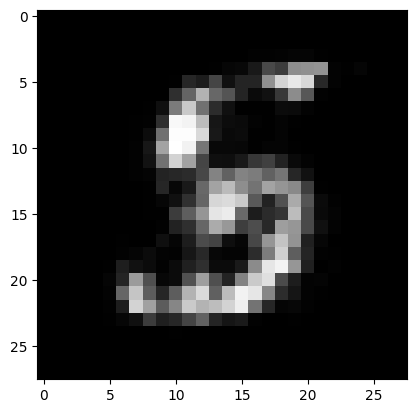

In [31]:
plt.imshow(image, cmap='gray')